# [Predictive Clinical Neuroscience Toolkit](https://github.com/amarquand/PCNtoolkit) 
# Normative Modeling Tutorial Using Multi-Site Cortical Thickness Data

### Created by [Saige Rutherford](https://twitter.com/being_saige) 

<div>
<img src="data/NormModelSetup.png" width="500"/>
</div>

## Step 0: Install necessary libraries & grab data files

In [ ]:
! wget -nc https://raw.githubusercontent.com/saigerutherford/PCNToolkit-demo/blob/master/requirements.txt

In [ ]:
! pip install -r requirements.txt

In [ ]:
! wget -nc https://raw.githubusercontent.com/saigerutherford/PCNToolkit-demo/blob/master/data/*.csv

In [ ]:
! wget -nc https://raw.githubusercontent.com/saigerutherford/PCNToolkit-demo/blob/master/data/roi_dir_names

## Step 1: Prepare covariate data

For this tutorial we will use data from the [Human Connectome Project Young Adult study](https://www.humanconnectome.org/study/hcp-young-adult), [CAMCAN](https://www.cam-can.org/), and [IXI](https://brain-development.org/ixi-dataset/) to create a multi-site dataset. 

Our first step is to prepare and combine the covariate (age & sex) data from each site.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joypy

In [2]:
hcp = pd.read_csv('data/HCP1200_age_gender.csv')

In [3]:
cam = pd.read_csv('data/cam_age_gender.csv')

In [4]:
cam_hcp = pd.merge(hcp, cam, on=["participant_id", "age", "sex", "site"], how='outer')

In [5]:
ixi = pd.read_csv('data/IXI_age_gender.csv')

In [6]:
cov = pd.merge(cam_hcp, ixi, on=["participant_id", "age", "sex", "site"], how='outer')

/Users/saigerutherford/opt/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1127: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


In [7]:
sns.set(font_scale=1.5, style='darkgrid')

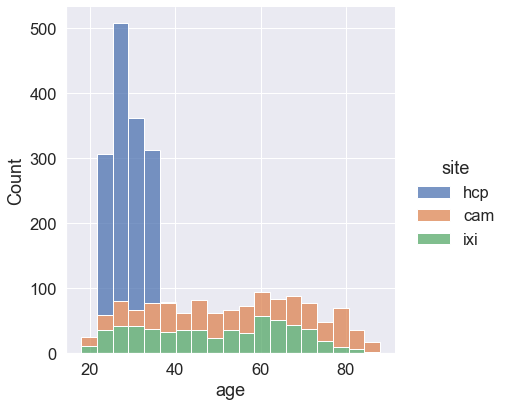

In [9]:
sns.displot(cov, x="age", hue="site", multiple="stack", height=6)

In [10]:
cov.groupby(['site']).describe()

age                                                                   \
       count       mean        std        min        25%       50%        75%   
site                                                                            
cam    656.0  54.419207  18.608285  18.000000  39.000000  55.00000  71.000000   
hcp   1206.0  28.837479   3.690534  22.000000  26.000000  29.00000  32.000000   
ixi    590.0  49.476531  16.720864  19.980835  34.027721  50.61191  63.413415   

                   sex                                               
           max   count      mean       std  min  25%  50%  75%  max  
site                                                                 
cam   88.00000   656.0  1.504573  0.500361  1.0  1.0  2.0  2.0  2.0  
hcp   37.00000  1206.0  1.543947  0.498272  1.0  1.0  2.0  2.0  2.0  
ixi   86.31896   590.0  1.555932  0.497283  1.0  1.0  2.0  2.0  2.0

# Step 2: Preprare brain data

Next we will format and combine the MRI data. We are using cortical thickness maps that are created by running recon-all from Freesurfer 6. We need to merge together the left and right hemisphere text files for each site, and then combine the different sites into a single dataframe. We reduce the dimensionality of our data by using ROIs from the Desikan-Killiany atlas. 

Here is some psuedo-code (run from a terminal in the folder that has all subject's recon-all output folders) that was used to extract these ROIs:

```export SUBJECTS_DIR=/path/to/study/freesurfer_data/```

```aparcstats2table --subject sub-* --hemi lh --meas thickness --tablefile HCP1200_aparc_lh_thickness.txt```

```aparcstats2table --subject sub-* --hemi rh --meas thickness --tablefile HCP1200_aparc_rh_thickness.txt```

In [11]:
# All of the ROIs in the Desikan-Killiany atlas (left & right hemisphere)
cols = ['participant_id', 'lh_bankssts_thickness', 'lh_caudalanteriorcingulate_thickness', 'lh_caudalmiddlefrontal_thickness', 'lh_cuneus_thickness',
       'lh_entorhinal_thickness', 'lh_fusiform_thickness', 'lh_inferiorparietal_thickness', 'lh_inferiortemporal_thickness', 'lh_isthmuscingulate_thickness', 'lh_lateraloccipital_thickness',
       'lh_lateralorbitofrontal_thickness', 'lh_lingual_thickness', 'lh_medialorbitofrontal_thickness', 'lh_middletemporal_thickness', 'lh_parahippocampal_thickness', 'lh_paracentral_thickness',
       'lh_parsopercularis_thickness', 'lh_parsorbitalis_thickness', 'lh_parstriangularis_thickness', 'lh_pericalcarine_thickness', 'lh_postcentral_thickness', 'lh_posteriorcingulate_thickness',
       'lh_precentral_thickness', 'lh_precuneus_thickness', 'lh_rostralanteriorcingulate_thickness', 'lh_rostralmiddlefrontal_thickness', 'lh_superiorfrontal_thickness',
       'lh_superiorparietal_thickness', 'lh_superiortemporal_thickness', 'lh_supramarginal_thickness', 'lh_frontalpole_thickness', 'lh_temporalpole_thickness', 'lh_transversetemporal_thickness',
       'lh_insula_thickness', 'lh_MeanThickness_thickness', 'rh_bankssts_thickness', 'rh_caudalanteriorcingulate_thickness', 'rh_caudalmiddlefrontal_thickness', 'rh_cuneus_thickness',
       'rh_entorhinal_thickness', 'rh_fusiform_thickness', 'rh_inferiorparietal_thickness', 'rh_inferiortemporal_thickness', 'rh_isthmuscingulate_thickness', 'rh_lateraloccipital_thickness',
       'rh_lateralorbitofrontal_thickness', 'rh_lingual_thickness', 'rh_medialorbitofrontal_thickness', 'rh_middletemporal_thickness', 'rh_parahippocampal_thickness', 'rh_paracentral_thickness',
       'rh_parsopercularis_thickness', 'rh_parsorbitalis_thickness', 'rh_parstriangularis_thickness', 'rh_pericalcarine_thickness', 'rh_postcentral_thickness', 'rh_posteriorcingulate_thickness',
       'rh_precentral_thickness', 'rh_precuneus_thickness', 'rh_rostralanteriorcingulate_thickness', 'rh_rostralmiddlefrontal_thickness', 'rh_superiorfrontal_thickness','rh_superiorparietal_thickness', 
       'rh_superiortemporal_thickness', 'rh_supramarginal_thickness', 'rh_frontalpole_thickness', 'rh_temporalpole_thickness', 'rh_transversetemporal_thickness', 'rh_insula_thickness', 'rh_MeanThickness_thickness']

In [12]:
cam = pd.read_csv('data/CAMCAN_aparc_thickness.csv')

In [13]:
hcpya = pd.read_csv('data/HCP1200_aparc_thickness.csv')

In [14]:
hcpya_cam = pd.merge(hcpya, cam, on=cols, how='outer')

In [15]:
ixi = pd.read_csv('data/IXI_aparc_thickness.csv')

In [16]:
brain_all = pd.merge(ixi, hcpya_cam, on=cols, how='outer')

We also want to include the [Euler number](https://mathworld.wolfram.com/EulerCharacteristic.html) as a covariate. So we extracted the euler number from each subject's recon-all output folder into a text file and we now need to format and combine these into our brain dataframe. 

Below is psuedo code for how we extracted the euler number from the recon-all.log for each subject. Run this from the terminal in the folder where your subjects recon-all output folders are located. This assumes that all of your subject IDs start with "sub-" prefix.

```for i in sub-*; do if [[ -e ${i}/scripts/recon-all.log ]]; then cat ${i}/scripts/recon-all.log | grep -A 1 "Computing euler" > temp_log; lh_en=`cat temp_log | head -2 | tail -1 | awk -F '=' '{print $2}' | awk -F ',' '{print $1}'`; rh_en=`cat temp_log | head -2 | tail -1 | awk -F '=' '{print $3}'`; echo "${i}, ${lh_en}, ${rh_en}" >> euler.csv; echo ${i}; fi; done```

In [17]:
hcp_euler = pd.read_csv('data/hcp-ya_euler.csv')
cam_euler = pd.read_csv('data/cam_euler.csv')
ixi_euler = pd.read_csv('data/ixi_euler.csv')

In [18]:
hcp_euler['site'] = 'hcp'
cam_euler['site'] = 'cam'
ixi_euler['site'] = 'ixi'

In [19]:
hcp_euler.replace(r'^\s*$', np.nan, regex=True, inplace=True)
cam_euler.replace(r'^\s*$', np.nan, regex=True, inplace=True)
ixi_euler.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [20]:
hcp_euler.dropna(inplace=True)
cam_euler.dropna(inplace=True)
ixi_euler.dropna(inplace=True)

In [21]:
hcp_euler['rh_euler'] = hcp_euler['rh_euler'].astype(int)
hcp_euler['lh_euler'] = hcp_euler['lh_euler'].astype(int)
cam_euler['rh_euler'] = cam_euler['rh_euler'].astype(int)
cam_euler['lh_euler'] = cam_euler['lh_euler'].astype(int)
ixi_euler['rh_euler'] = ixi_euler['rh_euler'].astype(int)
ixi_euler['lh_euler'] = ixi_euler['lh_euler'].astype(int)

In [22]:
hcp_cam_euler = pd.merge(hcp_euler, cam_euler, on=['participant_id', 'lh_euler', 'rh_euler', 'site'], how='outer')

In [23]:
df_euler = pd.merge(ixi_euler, hcp_cam_euler, on=['participant_id', 'lh_euler', 'rh_euler', 'site'], how='outer')

Finally, we need to center the euler number for each site. The euler number is very site-specific so in order to use the same exclusion threshold across sites we need to center the site by subtracting the site median from all subjects at a site. Then we will take the square root and multiply by negative one and exclude any subjects with a square root above 10. This choice of threshold is fairly random. If possible all of your data should be visually inspected to verify that the data inclusion is not too strict or too lenient. 

In [24]:
df_euler['avg_euler'] = df_euler[['lh_euler','rh_euler']].mean(axis=1)

In [25]:
df_euler.groupby(by='site').median()

,lh_euler,rh_euler,avg_euler
site,,,
cam,-62,-60,-61.0
hcp,-44,-44,-43.0
ixi,-58,-54,-56.0


In [26]:
df_euler['site_median'] = df_euler['site']

In [27]:
df_euler['site_median'] = df_euler['site_median'].replace({'hcp':-43,'cam':-61,'ixi':-56})

In [28]:
df_euler['avg_euler_centered'] = df_euler['avg_euler'] - df_euler['site_median']

In [29]:
df_euler['avg_euler_centered_neg'] = df_euler['avg_euler_centered']*-1

In [30]:
df_euler['avg_euler_centered_neg_sqrt'] = np.sqrt(np.absolute(df_euler['avg_euler_centered_neg']))

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2280x1520 with 0 Axes>

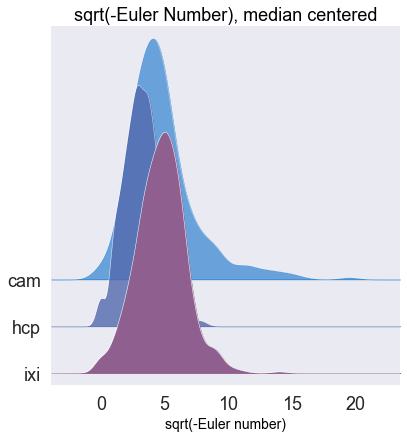

In [31]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#create a color gradent function to be used in the colormap parameter
def color_gradient(x=0.0, start=(0, 0, 0), stop=(1, 1, 1)):
    r = np.interp(x, [0, 1], [start[0], stop[0]])
    g = np.interp(x, [0, 1], [start[1], stop[1]])
    b = np.interp(x, [0, 1], [start[2], stop[2]])
    return r, g, b#show the table
#plot the figure
plt.figure(dpi=380)
fig, axes = joypy.joyplot(df_euler, column=['avg_euler_centered_neg_sqrt'], overlap=2.5, by="site", ylim='own', fill=True, figsize=(6,6)
                          , legend=False, xlabels=True, ylabels=True, colormap=lambda x: color_gradient(x, start=(.08, .45, .8),stop=(.8, .34, .44))
                          , alpha=0.6, linewidth=.5, linecolor='w', fade=True)
plt.title('sqrt(-Euler Number), median centered', fontsize=18, color='black', alpha=1)
plt.xlabel('sqrt(-Euler number)', fontsize=14, color='black', alpha=1)
plt.ylabel('Site', fontsize=14, color='black', alpha=1)
plt.show

In [32]:
brain = pd.merge(df_euler, brain_all, on=['participant_id'], how='inner')

In [33]:
len(brain)

2336

In [34]:
brain_good = brain.query('avg_euler_centered_neg_sqrt < 10')

In [35]:
len(brain_good)

2299

We lose 63 subjects because they have a large euler number.

# Step 3: Combine covariate & cortical thickness dataframes

Even though the normative modeling code needs the covariate and features (cortical thickness) in separate text files, we first need to merge them together to make sure that we have the same subjects in each file and that the rows (representing subjects) align. 

In [36]:
# make sure to use how="inner" so that we only include subjects that have data in both the covariate and the cortical thickness files 
all_data = pd.merge(brain_good, cov, on=['participant_id','site'], how='inner')

# Step 4: Format dataframes to run normative models

In [37]:
from sklearn.model_selection import train_test_split
import os
from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.utils import create_bspline_basis, compute_MSLL

In [38]:
# Remove any subjects that have NaN variables in any of the columns
all_data.dropna(subset=['lh_bankssts_thickness',
       'lh_caudalanteriorcingulate_thickness',
       'lh_caudalmiddlefrontal_thickness', 'lh_cuneus_thickness',
       'lh_entorhinal_thickness', 'lh_fusiform_thickness',
       'lh_inferiorparietal_thickness', 'lh_inferiortemporal_thickness',
       'lh_isthmuscingulate_thickness', 'lh_lateraloccipital_thickness',
       'lh_lateralorbitofrontal_thickness', 'lh_lingual_thickness',
       'lh_medialorbitofrontal_thickness', 'lh_middletemporal_thickness',
       'lh_parahippocampal_thickness', 'lh_paracentral_thickness',
       'lh_parsopercularis_thickness', 'lh_parsorbitalis_thickness',
       'lh_parstriangularis_thickness', 'lh_pericalcarine_thickness',
       'lh_postcentral_thickness', 'lh_posteriorcingulate_thickness',
       'lh_precentral_thickness', 'lh_precuneus_thickness',
       'lh_rostralanteriorcingulate_thickness',
       'lh_rostralmiddlefrontal_thickness', 'lh_superiorfrontal_thickness',
       'lh_superiorparietal_thickness', 'lh_superiortemporal_thickness',
       'lh_supramarginal_thickness', 'lh_frontalpole_thickness',
       'lh_temporalpole_thickness', 'lh_transversetemporal_thickness',
       'lh_insula_thickness', 'lh_MeanThickness_thickness',
       'rh_bankssts_thickness', 'rh_caudalanteriorcingulate_thickness',
       'rh_caudalmiddlefrontal_thickness', 'rh_cuneus_thickness',
       'rh_entorhinal_thickness', 'rh_fusiform_thickness',
       'rh_inferiorparietal_thickness', 'rh_inferiortemporal_thickness',
       'rh_isthmuscingulate_thickness', 'rh_lateraloccipital_thickness',
       'rh_lateralorbitofrontal_thickness', 'rh_lingual_thickness',
       'rh_medialorbitofrontal_thickness', 'rh_middletemporal_thickness',
       'rh_parahippocampal_thickness', 'rh_paracentral_thickness',
       'rh_parsopercularis_thickness', 'rh_parsorbitalis_thickness',
       'rh_parstriangularis_thickness', 'rh_pericalcarine_thickness',
       'rh_postcentral_thickness', 'rh_posteriorcingulate_thickness',
       'rh_precentral_thickness', 'rh_precuneus_thickness',
       'rh_rostralanteriorcingulate_thickness',
       'rh_rostralmiddlefrontal_thickness', 'rh_superiorfrontal_thickness',
       'rh_superiorparietal_thickness', 'rh_superiortemporal_thickness',
       'rh_supramarginal_thickness', 'rh_frontalpole_thickness',
       'rh_temporalpole_thickness', 'rh_transversetemporal_thickness',
       'rh_insula_thickness', 'rh_MeanThickness_thickness','age','sex'], inplace=True)

Separate the covariate & features into their own dataframes

In [39]:
all_data_features = all_data[['lh_bankssts_thickness',
       'lh_caudalanteriorcingulate_thickness',
       'lh_caudalmiddlefrontal_thickness', 'lh_cuneus_thickness',
       'lh_entorhinal_thickness', 'lh_fusiform_thickness',
       'lh_inferiorparietal_thickness', 'lh_inferiortemporal_thickness',
       'lh_isthmuscingulate_thickness', 'lh_lateraloccipital_thickness',
       'lh_lateralorbitofrontal_thickness', 'lh_lingual_thickness',
       'lh_medialorbitofrontal_thickness', 'lh_middletemporal_thickness',
       'lh_parahippocampal_thickness', 'lh_paracentral_thickness',
       'lh_parsopercularis_thickness', 'lh_parsorbitalis_thickness',
       'lh_parstriangularis_thickness', 'lh_pericalcarine_thickness',
       'lh_postcentral_thickness', 'lh_posteriorcingulate_thickness',
       'lh_precentral_thickness', 'lh_precuneus_thickness',
       'lh_rostralanteriorcingulate_thickness',
       'lh_rostralmiddlefrontal_thickness', 'lh_superiorfrontal_thickness',
       'lh_superiorparietal_thickness', 'lh_superiortemporal_thickness',
       'lh_supramarginal_thickness', 'lh_frontalpole_thickness',
       'lh_temporalpole_thickness', 'lh_transversetemporal_thickness',
       'lh_insula_thickness', 'lh_MeanThickness_thickness',
       'rh_bankssts_thickness', 'rh_caudalanteriorcingulate_thickness',
       'rh_caudalmiddlefrontal_thickness', 'rh_cuneus_thickness',
       'rh_entorhinal_thickness', 'rh_fusiform_thickness',
       'rh_inferiorparietal_thickness', 'rh_inferiortemporal_thickness',
       'rh_isthmuscingulate_thickness', 'rh_lateraloccipital_thickness',
       'rh_lateralorbitofrontal_thickness', 'rh_lingual_thickness',
       'rh_medialorbitofrontal_thickness', 'rh_middletemporal_thickness',
       'rh_parahippocampal_thickness', 'rh_paracentral_thickness',
       'rh_parsopercularis_thickness', 'rh_parsorbitalis_thickness',
       'rh_parstriangularis_thickness', 'rh_pericalcarine_thickness',
       'rh_postcentral_thickness', 'rh_posteriorcingulate_thickness',
       'rh_precentral_thickness', 'rh_precuneus_thickness',
       'rh_rostralanteriorcingulate_thickness',
       'rh_rostralmiddlefrontal_thickness', 'rh_superiorfrontal_thickness',
       'rh_superiorparietal_thickness', 'rh_superiortemporal_thickness',
       'rh_supramarginal_thickness', 'rh_frontalpole_thickness',
       'rh_temporalpole_thickness', 'rh_transversetemporal_thickness',
       'rh_insula_thickness', 'rh_MeanThickness_thickness']]

In [40]:
all_data_covariates = all_data[['age','sex','site']]

Right now, the sites are coded in a single column using a string. We need to instead dummy encode the site variable so that there is a column for each site and the columns contain binary variables (0/1). Luckily pandas has a nice built in function, ```pd.get_dummies``` to help us format the site column this way!

In [41]:
all_data_covariates = pd.get_dummies(all_data_covariates, columns=['site'])

In [42]:
all_data['Average_Thickness'] = all_data[['lh_MeanThickness_thickness','rh_MeanThickness_thickness']].mean(axis=1)

Take a sneak peak to see if there are any super obvious site effects. If there were, we would see a large separation in the fitted regression line for each site.

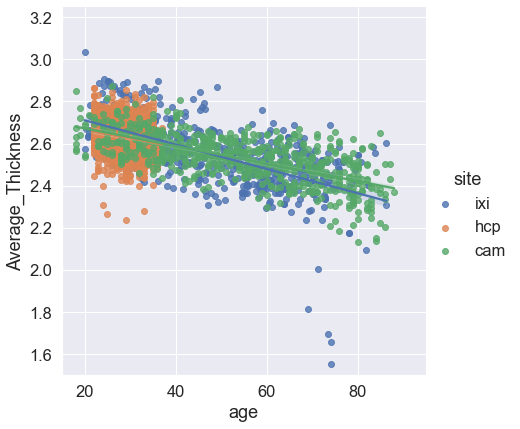

In [43]:
sns.set_theme(style="darkgrid",font_scale=1.5)
c = sns.lmplot(data=all_data, x="age", y="Average_Thickness", hue="site", height=6)
plt.ylim(1.5, 3.25)
plt.xlim(15, 95)
plt.show()

## Create train/test split

We will use 80% of the data for training and 20% for testing. We stratify our train/test split using the site variable to make sure that the train/test sets both contain data from all sites. The model wouldn't learn the site effects if all of the data from one site was only in the test set.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(all_data_covariates, all_data_features, stratify=all_data['site'], test_size=0.2, random_state=42)

Verify that your train & test arrays are the same size

In [45]:
tr_cov_size = X_train.shape
tr_resp_size = y_train.shape
te_cov_size = X_test.shape
te_resp_size = y_test.shape
print("Train covariate size is: ", tr_cov_size)
print("Test covariate size is: ", te_cov_size)
print("Train response size is: ", tr_resp_size)
print("Test response size is: ", te_resp_size)

Train covariate size is:  (1844, 5)
Test covariate size is:  (462, 5)
Train response size is:  (1844, 70)
Test response size is:  (462, 70)


### Save out each ROI to its own file

We setup the normative model so that for each Y (brain region) we fit a separate model. While the estimate function in the pcntoolkit can handle having all of the Y's in a single text file, for this tutorial we are going to organize our Y's so that they are each in their own text file and directory. 

In [46]:
for c in y_train.columns:
    y_train[c].to_csv('resp_tr_' + c + '.txt', header=False, index=False)

In [47]:
X_train.to_csv('cov_tr.txt', sep = '\t', header=False, index = False)

In [48]:
for c in y_test.columns:
    y_test[c].to_csv('resp_te_' + c + '.txt', header=False, index=False)

In [49]:
X_test.to_csv('cov_te.txt', sep = '\t', header=False, index = False)

In [50]:
! if [[ ! -e ROI_models/ ]]; then mkdir ROI_models; fi

In [51]:
! for i in `cat data/roi_dir_names`; do cd ROI_models; mkdir ${i}; cd ../; cp resp_tr_${i}.txt ROI_models/${i}/resp_tr.txt; cp resp_te_${i}.txt ROI_models/${i}/resp_te.txt; cp cov_tr.txt ROI_models/${i}/cov_tr.txt; cp cov_te.txt ROI_models/${i}/cov_te.txt; done 

In [52]:
! rm resp_*.txt

In [53]:
! rm cov_t*.txt

# Step 5: Run normative model

In [54]:
# set this path to wherever your ROI_models folder is located (where you copied all of the text files in the cells above)
data_dir = '/Users/saigerutherford/Desktop/lifespan/tutorial/ROI_models'

In [55]:
# which type of model to run?
cov_type = 'bspline'  # 'int', 'bspline' or None
warp = None   # 'WarpBoxCox', 'WarpSinArcsinh'  or None

# Create a cubic B-spline basis (used for regression)
xmin = 16 # Xmin & Xmax are the boundaries for ages of participants in the dataset
xmax = 90
B = create_bspline_basis(xmin, xmax)

[Reference for why we use B-spline in our design matrix](https://www.sciencedirect.com/science/article/abs/pii/S1053811910000832?via%3Dihub)

[Reference for what a B-spline is](https://cran.r-project.org/web/packages/crs/vignettes/spline_primer.pdf)

In [56]:
# Create a list of all the ROIs you want to run a normative model for
roi_ids = ['lh_bankssts_thickness',
       'lh_caudalanteriorcingulate_thickness']

When we split the data into train and test sets, we did not reset the index. This means that the row numbers in the train/test matrices are still the same as before splitting the data. We will need the test set row numbers of which subjects belong to which site in order to evaluate per site performance metrics, so we need to reset the row numbers in the train/test split matrices.

In [57]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [58]:
# Get indices of all the subejcts in each site so that we can evaluate the test set metrics per site
cam_idx = X_test.index[X_test['site_cam' ]== 1].to_list()
hcp_idx = X_test.index[X_test['site_hcp'] == 1].to_list()
ixi_idx = X_test.index[X_test['site_ixi'] == 1].to_list()

In [59]:
# Save the site indices into a single list
sites = [cam_idx, hcp_idx, ixi_idx]

In [60]:
# Create a list with sites names to use in evaluating per-site metrics
site_names = ['cam', 'hcp', 'ixi']

In [61]:
# Create pandas dataframes with header names to save out the overall and per-site model evaluation metrics
blr_metrics = pd.DataFrame(columns = ['ROI', 'MSLL', 'EV', 'SMSE', 'RMSE', 'Rho'])
blr_site_metrics = pd.DataFrame(columns = ['ROI', 'site', 'y_mean', 'y_var', 'yhat_mean', 'yhat_var', 'MSLL', 'EV', 'SMSE', 'RMSE', 'Rho'])

In [62]:
# This will loop through each ROI in the list roi_ids (that was set a few rows above)
# and run a normative model using Bayesian Linear Regression, then evaluate the normative model in the test set

for roi in roi_ids: 
    print('Running ROI:', roi)
    roi_dir = os.path.join(data_dir, roi)
    os.chdir(roi_dir)
    
    # set output dir 
    out_name = 'blr'
    if cov_type is not None:
        out_name += '_' + cov_type
    if warp is not None:
        out_name += '_' + warp
    os.makedirs(os.path.join(roi_dir,out_name), exist_ok=True)
    
    # load train & test covariate data matrices
    X_tr = np.loadtxt(os.path.join(roi_dir, 'cov_tr.txt'))
    X_te = np.loadtxt(os.path.join(roi_dir, 'cov_te.txt'))

    # add intercept column 
    X_tr = np.concatenate((X_tr, np.ones((X_tr.shape[0],1))), axis=1)
    X_te = np.concatenate((X_te, np.ones((X_te.shape[0],1))), axis=1)
    # save
    np.savetxt(os.path.join(roi_dir, 'cov_int_tr.txt'), X_tr)
    np.savetxt(os.path.join(roi_dir, 'cov_int_te.txt'), X_te)
    
    # create Bspline basis set 
    Phi = np.array([B(i) for i in X_tr[:,2]])
    Phis = np.array([B(i) for i in X_te[:,2]])
    X_tr = np.concatenate((X_tr, Phi), axis=1)
    X_te = np.concatenate((X_te, Phis), axis=1)
    # save
    np.savetxt(os.path.join(roi_dir, 'cov_bspline_tr.txt'), X_tr)
    np.savetxt(os.path.join(roi_dir, 'cov_bspline_te.txt'), X_te)
    
    # configure the covariates to use
    cov_file_tr = os.path.join(roi_dir, 'cov_') + cov_type + '_tr.txt'
    cov_file_te = os.path.join(roi_dir, 'cov_') + cov_type + '_te.txt'
    
    # load train & test response files
    resp_file_tr = os.path.join(roi_dir, 'resp_tr.txt')
    resp_file_te = os.path.join(roi_dir, 'resp_te.txt') 
    
    # run a basic model
    estimate(cov_file_tr, resp_file_tr, testresp=resp_file_te, testcov=cov_file_te, alg='blr', optimizer = 'powell', savemodel=False, standardize = False, warp=warp)
    
    # load training data (required for MSLL)
    y_tr = np.loadtxt(resp_file_tr)
    y_tr = y_tr[:, np.newaxis]
    
    # load test data, compute metrics on whole test set 
    X_te = np.loadtxt(cov_file_te)
    y_te = np.loadtxt(resp_file_te)
    y_te = y_te[:, np.newaxis]
    yhat_te = np.loadtxt(os.path.join(roi_dir, 'yhat_estimate.txt'))
    s2_te = np.loadtxt(os.path.join(roi_dir, 'ys2_estimate.txt'))
    yhat_te = yhat_te[:, np.newaxis]
    s2_te = s2_te[:, np.newaxis]
    metrics_te = evaluate(y_te, yhat_te, s2_te)
    y_mean_te = np.array([[np.mean(y_te)]])
    y_var_te = np.array([[np.var(y_te)]])
    MSLL_te = compute_MSLL(y_te, yhat_te, s2_te, y_mean_te, y_var_te)
    
    # compute metrics per site in test set
    for num, site in enumerate(sites):
        yhat_te_site = yhat_te[site]
        y_te_site = y_te[site]
        s2_te_site = s2_te[site]
        metrics_te_site = evaluate(y_te_site, yhat_te_site, s2_te_site)
        y_mean_te_site = np.array([[np.mean(y_te_site)]])
        y_var_te_site = np.array([[np.var(y_te_site)]])
        yhat_mean_te_site = np.array([[np.mean(yhat_te_site)]])
        yhat_var_te_site = np.array([[np.var(yhat_te_site)]])
        MSLL_te_site = compute_MSLL(y_te_site, yhat_te_site, s2_te_site, y_mean_te_site, y_var_te_site)
        site_name = site_names[num]
        print(site_name, ' EV = ', metrics_te_site['EXPV'])
        print(site_name, ' MSLL = ', MSLL_te_site) 
        blr_site_metrics.loc[len(blr_site_metrics)] = [roi,site_names[num],y_mean_te_site[0],y_var_te_site[0],yhat_mean_te_site[0],yhat_var_te_site[0],MSLL_te_site[0],metrics_te_site['EXPV'][0],metrics_te_site['SMSE'][0],metrics_te_site['RMSE'][0],metrics_te_site['Rho'][0]]
   
    #BIC = len(nm.blr.hyp) * np.log(y_tr.shape[0]) + 2 * nm.neg_log_lik
    #print('NLL =', nm.neg_log_lik)
    #print('BIC =', BIC)
    print('Full test set EV = ', metrics_te['EXPV'])
    print('Full test set MSLL = ', MSLL_te) 
    blr_metrics.loc[len(blr_metrics)] = [roi, MSLL_te[0],metrics_te['EXPV'][0],metrics_te['SMSE'][0],metrics_te['RMSE'][0],metrics_te['Rho'][0]]

Running ROI: lh_bankssts_thickness
Processing data in /Users/saigerutherford/Desktop/lifespan/tutorial/ROI_models/lh_bankssts_thickness/resp_tr.txt
Estimating model  1 of 1
initialising BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -779.620094
         Iterations: 2
         Function evaluations: 48
Evaluating the model ...
Writing outputs ...
cam  EV =  [0.17253832]
cam  MSLL =  [-0.08916152]
hcp  EV =  [0.01230968]
hcp  MSLL =  [0.00488419]
ixi  EV =  [0.16234589]
ixi  MSLL =  [0.01251656]
Full test set EV =  [0.16553676]
Full test set MSLL =  [-0.08963982]
Running ROI: lh_caudalanteriorcingulate_thickness
Processing data in /Users/saigerutherford/Desktop/lifespan/tutorial/ROI_models/lh_caudalanteriorcingulate_thickness/resp_tr.txt
Estimating model  1 of 1
initialising BLR ( order 1 )
Using default hyperparameters
Optimization terminated successfully.
         Current function value: -214.235162
         Iteration

In [63]:
os.chdir(data_dir)

/Users/saigerutherford/Desktop/lifespan/tutorial/ROI_models


In [64]:
# Save per site test set metrics variable to CSV file
blr_site_metrics.to_csv('blr_site_metrics.csv', index=False, index_label=None)

In [65]:
# Save overall test set metrics to CSV file
blr_metrics.to_csv('blr_metrics.csv', index=False, index_label=None)

# Step 6: Interpreting model performance

Output evaluation metrics definitions: 
* yhat - predictive mean
* ys2 - predictive variance
* nm - normative model
* Z - deviance scores
* Rho - Pearson correlation between true and predicted responses
* pRho - parametric p-value for this correlation
* RMSE - root mean squared error between true/predicted responses
* SMSE - standardised mean squared error
* EV - explained variance
* MSLL - mean square log loss
    * https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-log-error
    * https://medium.com/analytics-vidhya/understanding-the-loss-function-of-logistic-regression-ac1eec2838ce